In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from src.cleantext import *

In [545]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Import Yelp dataset

In [230]:
data = pd.read_csv('../cap2/data/predicted_review.csv').drop(columns= ['business_id', 'user_id'])

In [ ]:
data['True(1)/Deceptive(0)'] = (data['True(1)/Deceptive(0)'] == 'True').astype(bool)

In [ ]:
type(data['True(1)/Deceptive(0)'][0])

**seperating to 2 dfs**

In [ ]:
true = data[data['True(1)/Deceptive(0)'] == 1]

In [ ]:
true.to_csv('true.csv')

In [ ]:
decep = data[data['True(1)/Deceptive(0)'] == 0]
decep.to_csv('decep.csv')

In [ ]:
true = pd.read_csv('true.csv').drop(columns='Unnamed: 0')

In [ ]:
decep = pd.read_csv('decep.csv').drop(columns='Unnamed: 0')

Sample 100,000 data for faster processing

In [ ]:
true_samp = true.sample(100000, random_state = 123)

In [ ]:
decep_samp = decep.sample(100000, random_state = 123)

**pre processing the data**

clean text

In [ ]:
true_samp.Review = cleanText(true_samp.Review)

In [ ]:
decep_samp.Review = cleanText(decep_samp.Review)

tokenize

In [ ]:
import nltk
nltk.download('punkt')

In [ ]:
true_samp.Review = true_samp['Review'].apply(word_tokenize)

In [ ]:
decep_samp.Review = decep_samp['Review'].apply(word_tokenize)

Remove stopwords

In [ ]:
nltk.download('stopwords')

In [ ]:
stopwords_ = set(stopwords.words('english'))

In [ ]:
true_samp.Review = true_samp.Review.apply(lambda x: [item for item in x if item not in stopwords_ ])

In [ ]:
decep_samp.Review = decep_samp.Review.apply(lambda x: [item for item in x if item not in stopwords_ ])

Stemming

In [ ]:
stemmer = SnowballStemmer("english")
true_samp.Review = true_samp.Review.apply(lambda x: [stemmer.stem(y) for y in x])
decep_samp.Review = decep_samp.Review.apply(lambda x: [stemmer.stem(y) for y in x])

Detokenized

In [ ]:
true_samp.Review = true_samp.Review.apply(lambda x:' '.join([y for y in x ]))
decep_samp.Review = decep_samp.Review.apply(lambda x:' '.join([y for y in x ]))

In [ ]:
true_samp.to_csv('true_samp.csv')
decep_samp.to_csv('decep_samp.csv')

# Data Loaded to CSV checkpoint

In [611]:
true_samp = pd.read_csv('true_samp.csv')
true_samp.drop(columns='Unnamed: 0', inplace = True)

In [612]:
decep_samp = pd.read_csv('decep_samp.csv')
decep_samp.drop(columns='Unnamed: 0', inplace = True)

Vectorize

In [613]:
true_samp = true_samp[['Review', 'Stars']]

In [614]:
decep_samp = decep_samp[['Review','Stars']]

Use first 50k of sampled data for faster processing / able to keep track of the sample set

In [615]:
true_samp.Review = true_samp.Review.fillna('None')

In [11]:
true_samp_vec = vectorize(true_samp[:50000]['Review'], max_feat= 1000)

In [26]:
decep_samp.Review = decep_samp.Review.fillna('None')

In [27]:
decep_samp_vec = vectorize(decep_samp[:50000]['Review'], max_feat= 1000)

Combine vector with Stars feature 

In [28]:
decep_samp_vec['Stars'] = decep_samp['Stars'][:50000]

In [17]:
true_samp_vec['Stars'] = true_samp['Stars'][:50000]

Save vectors to pickle files

In [18]:
true_samp_vec.to_pickle('data/true_samp_vec_1000.pkl')

In [29]:
decep_samp_vec.to_pickle('data/decep_samp_vec_1000.pkl')

# Vectorized frames data checkpoint

In [4]:
true_samp_vec = pd.read_pickle('data/true_samp_vec_1000.pkl')
decep_samp_vec = pd.read_pickle('data/decep_samp_vec_1000.pkl')

split

In [603]:
X_true_train, X_true_test = train_test_split(true_samp_vec.iloc[:, :-1].values, test_size = 0.2, random_state = 123)

# MLP Auto Enconding Model

**First simple MLP auto encoding model with epoch = 5**

In [658]:
X_true_train, X_true_test = train_test_split(true_samp_vec.values, test_size = 0.2, random_state = 123)

In [660]:
#MLP model with rating feature
model = Sequential()
model.add(Dense(25, input_dim=X_true_train.shape[1], activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(X_true_train.shape[1])) # Multiple output neurons
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mse'])
hist = model.fit(X_true_train,X_true_train,verbose=1,epochs=5)

Train on 40000 samples
Epoch 1/5
40000/40000 [==============================] - 5s 127us/sample - loss: 0.0018 - mse: 0.0018
Epoch 2/5
40000/40000 [==============================] - 6s 141us/sample - loss: 9.6554e-04 - mse: 9.6554e-04
Epoch 3/5
40000/40000 [==============================] - 4s 108us/sample - loss: 9.5628e-04 - mse: 9.5628e-04s - loss: 9.5766e-04 - - ETA: 0s - loss: 9.5691e-04 -
Epoch 4/5
40000/40000 [==============================] - 3s 77us/sample - loss: 9.5151e-04 - mse: 9.5151e-04
Epoch 5/5
40000/40000 [==============================] - 3s 84us/sample - loss: 9.4874e-04 - mse: 9.4874e-04


In [661]:
pred = model.predict(X_true_test)
score1 = np.sqrt(metrics.mean_squared_error(pred,X_true_test))
pred = model.predict(true_samp_vec.values)
score2 = np.sqrt(metrics.mean_squared_error(pred,true_samp_vec.values))
pred = model.predict(decep_samp_vec.values)
score3 = np.sqrt(metrics.mean_squared_error(pred,decep_samp_vec.values))
print(f"Insample True Reviews Score (RMSE): {score1}".format(score1))
print(f"Out of Sample True Reviews Score (RMSE): {score2}")
print(f"Deceptive Reviews Score (RMSE): {score3}")

Insample True Reviews Score (RMSE): 0.030783265385156217
Out of Sample True Reviews Score (RMSE): 0.030775642340336477
Deceptive Reviews Score (RMSE): 0.03197437041912584


In [663]:
model2 = Sequential()
model2.add(Dense(25, input_dim=X_true_train.shape[1], activation='softmax'))
model2.add(Dense(3, activation='softmax'))
model2.add(Dense(25, activation='softmax'))
model2.add(Dense(X_true_train.shape[1])) # Multiple output neurons
model2.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mse'])
hist = model2.fit(X_true_train,X_true_train,verbose=1,epochs=5)

Train on 40000 samples
Epoch 1/5
40000/40000 [==============================] - 7s 166us/sample - loss: 0.0088 - mse: 0.0088
Epoch 2/5
40000/40000 [==============================] - 3s 86us/sample - loss: 0.0023 - mse: 0.0023
Epoch 3/5
40000/40000 [==============================] - 4s 95us/sample - loss: 0.0012 - mse: 0.00120s - loss: 0.0012 - mse: 0.00
Epoch 4/5
40000/40000 [==============================] - 4s 92us/sample - loss: 0.0011 - mse: 0.0011
Epoch 5/5
40000/40000 [==============================] - 4s 90us/sample - loss: 9.6529e-04 - mse: 9.6529e-04


In [664]:
pred = model2.predict(X_true_test)
score1 = np.sqrt(metrics.mean_squared_error(pred,X_true_test))
pred = model2.predict(true_samp_vec.values)
score2 = np.sqrt(metrics.mean_squared_error(pred,true_samp_vec.values))
pred = model2.predict(decep_samp_vec.values)
score3 = np.sqrt(metrics.mean_squared_error(pred,decep_samp_vec.values))
print(f"Insample True Reviews Score (RMSE): {score1}".format(score1))
print(f"Out of Sample True Reviews Score (RMSE): {score2}")
print(f"Deceptive Reviews Score (RMSE): {score3}")

Insample True Reviews Score (RMSE): 0.030880787261090187
Out of Sample True Reviews Score (RMSE): 0.03086279829699533
Deceptive Reviews Score (RMSE): 0.031989958444793944


In [665]:
model3 = Sequential()
model3.add(Dense(25, input_dim=X_true_train.shape[1], activation='relu'))
model3.add(Dense(3, activation='relu'))
model3.add(Dense(25, activation='softmax'))
model3.add(Dense(X_true_train.shape[1])) # Multiple output neurons
model3.compile(loss='mean_squared_error', optimizer='rmsprop', metrics = ['mse'])
hist = model3.fit(X_true_train,X_true_train,verbose=1,epochs=5)

Train on 40000 samples
Epoch 1/5
40000/40000 [==============================] - 7s 164us/sample - loss: 0.0086 - mse: 0.0086
Epoch 2/5
40000/40000 [==============================] - 3s 85us/sample - loss: 0.0018 - mse: 0.0018
Epoch 3/5
40000/40000 [==============================] - 3s 81us/sample - loss: 9.7465e-04 - mse: 9.7465e-04
Epoch 4/5
40000/40000 [==============================] - 3s 67us/sample - loss: 9.4686e-04 - mse: 9.4686e-04
Epoch 5/5
40000/40000 [==============================] - 3s 75us/sample - loss: 9.4461e-04 - mse: 9.4461e-041


In [666]:
pred = model3.predict(X_true_test)
score1 = np.sqrt(metrics.mean_squared_error(pred,X_true_test))
pred = model3.predict(true_samp_vec.values)
score2 = np.sqrt(metrics.mean_squared_error(pred,true_samp_vec.values))
pred = model3.predict(decep_samp_vec.values)
score3 = np.sqrt(metrics.mean_squared_error(pred,decep_samp_vec.values))
print(f"Insample True Reviews Score (RMSE): {score1}".format(score1))
print(f"Out of Sample True Reviews Score (RMSE): {score2}")
print(f"Deceptive Reviews Score (RMSE): {score3}")

Insample True Reviews Score (RMSE): 0.030743281631962865
Out of Sample True Reviews Score (RMSE): 0.030735853780510736
Deceptive Reviews Score (RMSE): 0.03190633442892839


In [978]:
model4 = Sequential()
model4.add(Dense(25, input_dim=X_true_train.shape[1], activation='relu'))
model4.add(Dense(3, activation='relu'))
model4.add(Dense(25, activation='softmax'))
model4.add(Dense(X_true_train.shape[1])) # Multiple output neurons
model4.compile(loss='mean_squared_error', optimizer='rmsprop', metrics = ['mse'])
hist = model4.fit(X_true_train,X_true_train,verbose=1,epochs=20)

Train on 40000 samples
Epoch 1/20
40000/40000 [==============================] - 7s 177us/sample - loss: 0.0086 - mse: 0.0086
Epoch 2/20
40000/40000 [==============================] - 4s 107us/sample - loss: 0.0018 - mse: 0.0018
Epoch 3/20
40000/40000 [==============================] - 3s 83us/sample - loss: 9.7014e-04 - mse: 9.7014e-04
Epoch 4/20
40000/40000 [==============================] - 3s 81us/sample - loss: 9.4642e-04 - mse: 9.4643e-041s - 
Epoch 5/20
40000/40000 [==============================] - 4s 105us/sample - loss: 9.4314e-04 - mse: 9.4314e-04
Epoch 6/20
40000/40000 [==============================] - 3s 85us/sample - loss: 9.4000e-04 - mse: 9.4000e-04
Epoch 7/20
40000/40000 [==============================] - 3s 72us/sample - loss: 9.3849e-04 - mse: 9.3849e-04
Epoch 8/20
40000/40000 [==============================] - 3s 71us/sample - loss: 9.3766e-04 - mse: 9.3767e-040s - loss: 9.3768e-04 - mse: 9.3768e-
Epoch 9/20
40000/40000 [==============================] - 3s 73us/sa

In [980]:
model5 = Sequential()
model5.add(Dense(25, input_dim=X_true_train.shape[1], activation='relu'))
model5.add(Dense(3, activation='relu'))
model5.add(Dense(25, activation='softmax'))
model5.add(Dense(X_true_train.shape[1])) # Multiple output neurons
model5.compile(loss='mean_squared_error', optimizer='rmsprop', metrics = ['mse'])
hist = model5.fit(X_true_train,X_true_train,verbose=1,epochs=40)

Train on 40000 samples
Epoch 1/40
40000/40000 [==============================] - 5s 125us/sample - loss: 0.0086 - mse: 0.0086
Epoch 2/40
40000/40000 [==============================] - 2s 60us/sample - loss: 0.0018 - mse: 0.00180s - loss: 0.0019 - mse:
Epoch 3/40
40000/40000 [==============================] - 2s 62us/sample - loss: 9.7379e-04 - mse: 9.7379e-04
Epoch 4/40
40000/40000 [==============================] - 2s 56us/sample - loss: 9.4422e-04 - mse: 9.4422e-04
Epoch 5/40
40000/40000 [==============================] - 2s 59us/sample - loss: 9.4010e-04 - mse: 9.4010e-04
Epoch 6/40
40000/40000 [==============================] - 3s 68us/sample - loss: 9.3767e-04 - mse: 9.3767e-04
Epoch 7/40
40000/40000 [==============================] - 2s 58us/sample - loss: 9.3564e-04 - mse: 9.3564e-04
Epoch 8/40
40000/40000 [==============================] - 2s 53us/sample - loss: 9.3469e-04 - mse: 9.3469e-04
Epoch 9/40
40000/40000 [==============================] - 2s 58us/sample - loss: 9.3414e

In [48]:
model6 = Sequential()
model6.add(Dense(25, input_dim=X_true_train.shape[1], activation='relu'))
model6.add(Dense(3, activation='relu'))
model6.add(Dense(25, activation='relu'))
model6.add(Dense(X_true_train.shape[1])) # Multiple output neurons
model6.compile(loss='mean_squared_error', optimizer='adam' )
model6.fit(X_true_train,X_true_train,verbose=1,epochs=100)

Train on 40000 samples
Epoch 1/100
40000/40000 [==============================] - 2s 62us/sample - loss: 0.0020
Epoch 2/100
40000/40000 [==============================] - 2s 58us/sample - loss: 9.6395e-04
Epoch 3/100
40000/40000 [==============================] - 2s 62us/sample - loss: 9.5401e-040s - loss: 9.54
Epoch 4/100
40000/40000 [==============================] - 2s 54us/sample - loss: 9.5071e-04
Epoch 5/100
40000/40000 [==============================] - 2s 55us/sample - loss: 9.4747e-041s - loss: 9. - ETA: 0s - l
Epoch 6/100
40000/40000 [==============================] - 2s 55us/sample - loss: 9.4516e-040s - loss: 9.
Epoch 7/100
40000/40000 [==============================] - 2s 54us/sample - loss: 9.4338e-040s - loss: 
Epoch 8/100
40000/40000 [==============================] - 3s 63us/sample - loss: 9.4183e-04
Epoch 9/100
40000/40000 [==============================] - 3s 63us/sample - loss: 9.4083e-04
Epoch 10/100
40000/40000 [==============================] - 2s 58us/sample - l

40000/40000 [==============================] - 2s 59us/sample - loss: 9.1310e-04TA: 0s
Epoch 81/100
40000/40000 [==============================] - 2s 60us/sample - loss: 9.1310e-04
Epoch 82/100
40000/40000 [==============================] - 2s 53us/sample - loss: 9.1300e-04
Epoch 83/100
40000/40000 [==============================] - 2s 57us/sample - loss: 9.1298e-040s - l - ETA: 0s - loss: 9.1316
Epoch 84/100
40000/40000 [==============================] - 2s 51us/sample - loss: 9.1290e-04
Epoch 85/100
40000/40000 [==============================] - 2s 59us/sample - loss: 9.1295e-04
Epoch 86/100
40000/40000 [==============================] - 2s 57us/sample - loss: 9.1287e-040s - loss - ETA: 0s - loss: 9.1301e
Epoch 87/100
40000/40000 [==============================] - 2s 57us/sample - loss: 9.1281e-04
Epoch 88/100
40000/40000 [==============================] - 2s 54us/sample - loss: 9.1277e-040s - loss: 9.1269
Epoch 89/100
40000/40000 [==============================] - 2s 56us/sample - l

In [49]:
pred = model6.predict(X_true_test)
score1 = np.sqrt(metrics.mean_squared_error(pred,X_true_test))
pred = model6.predict(true_samp_vec.values)
score2 = np.sqrt(metrics.mean_squared_error(pred,true_samp_vec.values))
pred = model6.predict(decep_samp_vec.values)
score3 = np.sqrt(metrics.mean_squared_error(pred,decep_samp_vec.values))
print(f"Insample True Reviews Score (RMSE): {score1}".format(score1))
print(f"Out of Sample True Reviews Score (RMSE): {score2}")
print(f"Deceptive Reviews Score (RMSE): {score3}")

Insample True Reviews Score (RMSE): 0.030218103642040493
Out of Sample True Reviews Score (RMSE): 0.030201460947785495
Deceptive Reviews Score (RMSE): 0.031650776964433885


In [182]:
model7 = Sequential()
model7.add(Dense(200, input_dim=X_true_train.shape[1], activation='relu'))
model7.add(Dense(50, activation='relu'))
model7.add(Dense(4, activation='relu'))
model7.add(Dense(50, activation='relu'))
model7.add(Dense(200, activation='relu'))
model7.add(Dense(X_true_train.shape[1])) # Multiple output neurons
model7.compile(loss='mean_squared_error', optimizer='adam' )
model7.fit(X_true_train,X_true_train,verbose=1,epochs=10)

Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 4s 98us/sample - loss: 0.0013
Epoch 2/10
40000/40000 [==============================] - 4s 98us/sample - loss: 9.6960e-040
Epoch 3/10
40000/40000 [==============================] - 4s 91us/sample - loss: 9.5771e-04
Epoch 4/10
40000/40000 [==============================] - 4s 90us/sample - loss: 9.5161e-04
Epoch 5/10
40000/40000 [==============================] - 4s 89us/sample - loss: 9.4736e-04
Epoch 6/10
40000/40000 [==============================] - 4s 89us/sample - loss: 9.4209e-04
Epoch 7/10
40000/40000 [==============================] - 4s 92us/sample - loss: 9.3928e-04
Epoch 8/10
40000/40000 [==============================] - 3s 85us/sample - loss: 9.3710e-04
Epoch 9/10
40000/40000 [==============================] - 4s 96us/sample - loss: 9.3542e-04
Epoch 10/10
40000/40000 [==============================] - 4s 89us/sample - loss: 9.3385e-04


In [183]:
pred = model7.predict(X_true_test)
score1 = np.sqrt(metrics.mean_squared_error(pred,X_true_test))
pred = model7.predict(true_samp_vec.values)
score2 = np.sqrt(metrics.mean_squared_error(pred,true_samp_vec.values))
pred = model7.predict(decep_samp_vec.values)
score3 = np.sqrt(metrics.mean_squared_error(pred,decep_samp_vec.values))
print(f"Insample True Reviews Score (RMSE): {score1}".format(score1))
print(f"Out of Sample True Reviews Score (RMSE): {score2}")
print(f"Deceptive Reviews Score (RMSE): {score3}")

Insample True Reviews Score (RMSE): 0.030559000089406357
Out of Sample True Reviews Score (RMSE): 0.030537694284503543
Deceptive Reviews Score (RMSE): 0.03186873998458336


**CHOOSE MODEL 3 since there's not much different in d

In [673]:
model3.evaluate(X_true_test, X_true_test) #loss fn

10000/10000 [==============================] - 1s 103us/sample - loss: 9.4515e-04 - mse: 9.4515e-04


[0.000945149357803166, 0.00094514934]

In [686]:
#get a list of training loss values so we can plot the histogram
X_true_train_loss = []
for i in range(X_true_train.shape[0]):
    X_true_train_loss.append(model3.evaluate(X_true_train[i].reshape(1,1001),X_true_train[i].reshape(1,1001))[0])

1/1 [==============================] - 0s 2ms/sample - loss: 9.2884e-04 - mse: 9.2884e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6825e-04 - mse: 9.6825e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.2595e-04 - mse: 9.2595e-04


1/1 [==============================] - 0s 15ms/sample - loss: 8.7870e-04 - mse: 8.7870e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4235e-04 - mse: 9.4235e-04


1/1 [==============================] - 0s 4ms/sample - loss: 9.0083e-04 - mse: 9.0083e-04


1/1 [==============================] - 0s 6ms/sample - loss: 9.4968e-04 - mse: 9.4968e-04


1/1 [==============================] - 0s 5ms/sample - loss: 9.5352e-04 - mse: 9.5352e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6390e-04 - mse: 9.6390e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.4911e-04 - mse: 8.4911e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6330e-04 - mse: 9.6330e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.3431e-04 - mse: 9.3431e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.5666e-04 - mse: 9.5666e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.9251e-04 - mse: 8.9251e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6886e-04 - mse: 9.6886e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 5ms/sample - loss: 9.7005e-04 - mse: 9.7005e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.1783e-04 - mse: 9.1783e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.7833e-04 - mse: 9.7833e-04


1/1 [==============================] - 0s 23ms/sample - loss: 9.7201e-04 - mse: 9.7201e-04


1/1 [==============================] - 0s 8ms/sample - loss: 9.1788e-04 - mse: 9.1788e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6240e-04 - mse: 9.6240e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4653e-04 - mse: 9.4653e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.0635e-04 - mse: 9.0635e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.5792e-04 - mse: 9.5792e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2701e-04 - mse: 9.2701e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.3265e-04 - mse: 9.3265e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 9.6638e-04 - mse: 9.6638e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.4881e-04 - mse: 9.4881e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.5859e-04 - mse: 9.5859e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.3719e-04 - mse: 9.3719e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4416e-04 - mse: 9.4416e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.9397e-04 - mse: 9.9397e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.0745e-04 - mse: 9.0745e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4640e-04 - mse: 9.4640e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.5067e-04 - mse: 8.5067e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6103e-04 - mse: 9.6103e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.9638e-04 - mse: 8.9638e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2600e-04 - mse: 9.2600e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.3630e-04 - mse: 9.3630e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2428e-04 - mse: 9.2428e-04


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 1ms/sample - loss: 9.1516e-04 - mse: 9.1516e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.1079e-04 - mse: 9.1079e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.3107e-04 - mse: 9.3107e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.0352e-04 - mse: 9.0352e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.6898e-04 - mse: 8.6898e-04


1/1 [==============================] - 0s 12ms/sample - loss: 9.5817e-04 - mse: 9.5817e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.3827e-04 - mse: 9.3827e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4351e-04 - mse: 9.4351e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.7791e-04 - mse: 9.7791e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.9731e-04 - mse: 9.9731e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2155e-04 - mse: 9.2155e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.3058e-04 - mse: 9.3058e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.5031e-04 - mse: 9.5031e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.8921e-04 - mse: 9.8921e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.3441e-04 - mse: 9.3441e-04


1/1 [==============================] - 0s 4ms/sample - loss: 9.6422e-04 - mse: 9.6422e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.5580e-04 - mse: 8.5580e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.8786e-04 - mse: 8.8786e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.3521e-04 - mse: 9.3521e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6255e-04 - mse: 9.6255e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.3323e-04 - mse: 9.3323e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.6806e-04 - mse: 8.6806e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.3040e-04 - mse: 9.3040e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.2284e-04 - mse: 9.2284e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4970e-04 - mse: 9.4970e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2446e-04 - mse: 9.2446e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.6391e-04 - mse: 9.6391e-04


1/1 [==============================] - 0s 4ms/sample - loss: 9.2295e-04 - mse: 9.2295e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.3944e-04 - mse: 9.3944e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2823e-04 - mse: 9.2823e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.3200e-04 - mse: 9.3200e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 1ms/sample - loss: 9.4937e-04 - mse: 9.4937e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.1545e-04 - mse: 9.1545e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6575e-04 - mse: 9.6575e-04


1/1 [==============================] - 0s 15ms/sample - loss: 9.2374e-04 - mse: 9.2374e-04


1/1 [==============================] - 0s 1ms/sample - loss: 8.9030e-04 - mse: 8.9030e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2453e-04 - mse: 9.2453e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6882e-04 - mse: 9.6882e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.5850e-04 - mse: 9.5850e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.1933e-04 - mse: 9.1933e-04


1/1 [==============================] - 0s 1ms/sample - loss: 8.8724e-04 - mse: 8.8724e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.1895e-04 - mse: 9.1895e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4939e-04 - mse: 9.4939e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.8611e-04 - mse: 9.8611e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4024e-04 - mse: 9.4024e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.5402e-04 - mse: 9.5402e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.5798e-04 - mse: 9.5798e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.7214e-04 - mse: 9.7214e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.4148e-04 - mse: 9.4148e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4583e-04 - mse: 9.4583e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2430e-04 - mse: 9.2430e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.8550e-04 - mse: 9.8550e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.1311e-04 - mse: 9.1311e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.0548e-04 - mse: 9.0548e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6807e-04 - mse: 9.6807e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6231e-04 - mse: 9.6231e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4000e-04 - mse: 9.4000e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6319e-04 - mse: 9.6319e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4797e-04 - mse: 9.4797e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6240e-04 - mse: 9.6240e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.7034e-04 - mse: 9.7034e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.5028e-04 - mse: 9.5028e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6041e-04 - mse: 9.6041e-04


1/1 [==============================] - 0s 11ms/sample - loss: 9.3588e-04 - mse: 9.3588e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.5485e-04 - mse: 9.5485e-04


1/1 [==============================] - 0s 9ms/sample - loss: 8.8288e-04 - mse: 8.8288e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.3657e-04 - mse: 9.3657e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.8692e-04 - mse: 9.8692e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4341e-04 - mse: 9.4341e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.8224e-04 - mse: 9.8224e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4754e-04 - mse: 9.4754e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.3051e-04 - mse: 9.3051e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0011 - mse: 0.0011


1/1 [==============================] - 0s 2ms/sample - loss: 9.4437e-04 - mse: 9.4437e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.9573e-04 - mse: 9.9573e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.5081e-04 - mse: 9.5081e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.2761e-04 - mse: 9.2761e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.4172e-04 - mse: 9.4172e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.3684e-04 - mse: 9.3684e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.1672e-04 - mse: 9.1672e-04


1/1 [==============================] - 0s 11ms/sample - loss: 9.5662e-04 - mse: 9.5662e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.0586e-04 - mse: 9.0586e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4752e-04 - mse: 9.4752e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.5870e-04 - mse: 9.5870e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.8580e-04 - mse: 8.8580e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6138e-04 - mse: 9.6138e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6122e-04 - mse: 9.6122e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.9495e-04 - mse: 8.9495e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.2950e-04 - mse: 8.2950e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.5483e-04 - mse: 9.5483e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6173e-04 - mse: 9.6173e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4328e-04 - mse: 9.4328e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.1237e-04 - mse: 9.1237e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2782e-04 - mse: 9.2782e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4078e-04 - mse: 9.4078e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.7603e-04 - mse: 9.7603e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.1926e-04 - mse: 9.1926e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.3081e-04 - mse: 9.3081e-04


1/1 [==============================] - 0s 4ms/sample - loss: 9.4170e-04 - mse: 9.4170e-04


1/1 [==============================] - 0s 8ms/sample - loss: 9.9451e-04 - mse: 9.9451e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.5533e-04 - mse: 9.5533e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.1096e-04 - mse: 9.1096e-04


1/1 [==============================] - 0s 5ms/sample - loss: 9.7184e-04 - mse: 9.7184e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2859e-04 - mse: 9.2859e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4553e-04 - mse: 9.4553e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.9779e-04 - mse: 9.9779e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6229e-04 - mse: 9.6229e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 1ms/sample - loss: 8.6785e-04 - mse: 8.6785e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.0517e-04 - mse: 9.0517e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.4068e-04 - mse: 8.4068e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.1124e-04 - mse: 9.1124e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.2433e-04 - mse: 9.2433e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.3117e-04 - mse: 9.3117e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.4136e-04 - mse: 9.4136e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.3701e-04 - mse: 9.3701e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.2068e-04 - mse: 9.2068e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.6764e-04 - mse: 9.6764e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.9983e-04 - mse: 8.9983e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.7200e-04 - mse: 9.7200e-04


1/1 [==============================] - 0s 1ms/sample - loss: 8.8182e-04 - mse: 8.8182e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6429e-04 - mse: 9.6429e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6027e-04 - mse: 9.6027e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4170e-04 - mse: 9.4170e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.6207e-04 - mse: 9.6207e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6128e-04 - mse: 9.6128e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.7922e-04 - mse: 9.7922e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.8433e-04 - mse: 9.8433e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.4521e-04 - mse: 9.4521e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.8804e-04 - mse: 8.8804e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.1107e-04 - mse: 9.1107e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2752e-04 - mse: 9.2752e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.2265e-04 - mse: 9.2265e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.8063e-04 - mse: 8.8063e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.9427e-04 - mse: 8.9427e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.3270e-04 - mse: 9.3270e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.5731e-04 - mse: 9.5731e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4063e-04 - mse: 9.4063e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2681e-04 - mse: 9.2681e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4846e-04 - mse: 9.4846e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.6329e-04 - mse: 9.6329e-04


1/1 [==============================] - 0s 8ms/sample - loss: 9.8161e-04 - mse: 9.8161e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.3497e-04 - mse: 9.3497e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4276e-04 - mse: 9.4276e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.5313e-04 - mse: 9.5313e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.3393e-04 - mse: 9.3393e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2090e-04 - mse: 9.2090e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.1079e-04 - mse: 9.1079e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.7105e-04 - mse: 9.7105e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2298e-04 - mse: 9.2298e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.7996e-04 - mse: 8.7996e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.5672e-04 - mse: 9.5672e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 8.8805e-04 - mse: 8.8805e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4069e-04 - mse: 9.4069e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.8432e-04 - mse: 8.8432e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2282e-04 - mse: 9.2282e-04


1/1 [==============================] - 0s 7ms/sample - loss: 9.4423e-04 - mse: 9.4423e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.4391e-04 - mse: 9.4391e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.0863e-04 - mse: 9.0863e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.0428e-04 - mse: 9.0428e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.3232e-04 - mse: 9.3232e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.7359e-04 - mse: 8.7359e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.0015e-04 - mse: 9.0015e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2779e-04 - mse: 9.2779e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2492e-04 - mse: 9.2492e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.1789e-04 - mse: 9.1789e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.7346e-04 - mse: 9.7346e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.7449e-04 - mse: 9.7449e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2715e-04 - mse: 9.2715e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.9742e-04 - mse: 8.9742e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2568e-04 - mse: 9.2568e-04


1/1 [==============================] - 0s 8ms/sample - loss: 9.4066e-04 - mse: 9.4066e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6463e-04 - mse: 9.6463e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2901e-04 - mse: 9.2901e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.5880e-04 - mse: 9.5880e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2213e-04 - mse: 9.2213e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2778e-04 - mse: 9.2778e-04


1/1 [==============================] - 0s 13ms/sample - loss: 8.7645e-04 - mse: 8.7645e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4836e-04 - mse: 9.4836e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4126e-04 - mse: 9.4126e-04


1/1 [==============================] - 0s 4ms/sample - loss: 9.9387e-04 - mse: 9.9387e-04


1/1 [==============================] - 0s 3ms/sample - loss: 8.7855e-04 - mse: 8.7855e-04


1/1 [==============================] - 0s 4ms/sample - loss: 9.3116e-04 - mse: 9.3116e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6287e-04 - mse: 9.6287e-04


1/1 [==============================] - 0s 4ms/sample - loss: 8.8406e-04 - mse: 8.8406e-04


1/1 [==============================] - 0s 4ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.2840e-04 - mse: 9.2840e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.3730e-04 - mse: 9.3730e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.9673e-04 - mse: 8.9673e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.1021e-04 - mse: 9.1021e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.1947e-04 - mse: 9.1947e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.5499e-04 - mse: 9.5499e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.5811e-04 - mse: 9.5811e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.5140e-04 - mse: 9.5140e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6850e-04 - mse: 9.6850e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.1721e-04 - mse: 9.1721e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.4773e-04 - mse: 9.4773e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4038e-04 - mse: 9.4038e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.4371e-04 - mse: 9.4371e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.3483e-04 - mse: 9.3483e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.5505e-04 - mse: 9.5505e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2417e-04 - mse: 9.2417e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6082e-04 - mse: 9.6082e-04


1/1 [==============================] - 0s 11ms/sample - loss: 9.8539e-04 - mse: 9.8539e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4323e-04 - mse: 9.4323e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4365e-04 - mse: 9.4365e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6806e-04 - mse: 9.6806e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4226e-04 - mse: 9.4226e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.9506e-04 - mse: 9.9506e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4138e-04 - mse: 9.4138e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.7535e-04 - mse: 9.7535e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4973e-04 - mse: 9.4973e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4084e-04 - mse: 9.4084e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.3938e-04 - mse: 9.3938e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.2933e-04 - mse: 9.2933e-04


1/1 [==============================] - 0s 3ms/sample - loss: 8.9035e-04 - mse: 8.9035e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.8915e-04 - mse: 9.8915e-04


1/1 [==============================] - 0s 9ms/sample - loss: 9.1024e-04 - mse: 9.1024e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4497e-04 - mse: 9.4497e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.7733e-04 - mse: 9.7733e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.9608e-04 - mse: 8.9608e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.7705e-04 - mse: 8.7705e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.8157e-04 - mse: 9.8157e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 9.3689e-04 - mse: 9.3689e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.3724e-04 - mse: 9.3724e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.5712e-04 - mse: 9.5712e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.0608e-04 - mse: 9.0608e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.7053e-04 - mse: 9.7053e-04


1/1 [==============================] - 0s 4ms/sample - loss: 9.6258e-04 - mse: 9.6258e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4834e-04 - mse: 9.4834e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.3110e-04 - mse: 9.3110e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.7609e-04 - mse: 8.7609e-04


1/1 [==============================] - 0s 7ms/sample - loss: 9.4744e-04 - mse: 9.4744e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.5457e-04 - mse: 9.5457e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.2637e-04 - mse: 9.2637e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.9416e-04 - mse: 9.9416e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.9531e-04 - mse: 9.9531e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.8374e-04 - mse: 8.8374e-04


1/1 [==============================] - 0s 5ms/sample - loss: 8.8651e-04 - mse: 8.8651e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.7662e-04 - mse: 9.7662e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.8949e-04 - mse: 8.8949e-04


1/1 [==============================] - 0s 6ms/sample - loss: 9.3076e-04 - mse: 9.3076e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6813e-04 - mse: 9.6813e-04


1/1 [==============================] - 0s 3ms/sample - loss: 8.7879e-04 - mse: 8.7879e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.7374e-04 - mse: 9.7374e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.5171e-04 - mse: 9.5171e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.1084e-04 - mse: 9.1084e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.7283e-04 - mse: 9.7283e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.6807e-04 - mse: 8.6807e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.9030e-04 - mse: 9.9030e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.5299e-04 - mse: 9.5299e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.0220e-04 - mse: 9.0220e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.1547e-04 - mse: 9.1547e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6206e-04 - mse: 9.6206e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.1054e-04 - mse: 9.1054e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.7956e-04 - mse: 9.7956e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.7711e-04 - mse: 9.7711e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.0756e-04 - mse: 9.0756e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2841e-04 - mse: 9.2841e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.5682e-04 - mse: 9.5682e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6957e-04 - mse: 9.6957e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.1079e-04 - mse: 9.1079e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.5191e-04 - mse: 9.5191e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.7901e-04 - mse: 9.7901e-04


1/1 [==============================] - 0s 1ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.9376e-04 - mse: 9.9376e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.9364e-04 - mse: 9.9364e-04


1/1 [==============================] - 0s 5ms/sample - loss: 9.4429e-04 - mse: 9.4429e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.8848e-04 - mse: 9.8848e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2898e-04 - mse: 9.2898e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.5405e-04 - mse: 8.5405e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4771e-04 - mse: 9.4771e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.1263e-04 - mse: 9.1263e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4264e-04 - mse: 9.4264e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4398e-04 - mse: 9.4398e-04


1/1 [==============================] - 0s 3ms/sample - loss: 8.7790e-04 - mse: 8.7790e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2945e-04 - mse: 9.2945e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.5970e-04 - mse: 9.5970e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6406e-04 - mse: 9.6406e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.3339e-04 - mse: 9.3339e-04


1/1 [==============================] - 0s 52ms/sample - loss: 9.0855e-04 - mse: 9.0855e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.2523e-04 - mse: 9.2523e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.5567e-04 - mse: 9.5567e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.1227e-04 - mse: 9.1227e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.3862e-04 - mse: 9.3862e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2993e-04 - mse: 9.2993e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.4761e-04 - mse: 9.4761e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.4198e-04 - mse: 9.4198e-04


1/1 [==============================] - 0s 3ms/sample - loss: 8.4702e-04 - mse: 8.4702e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4951e-04 - mse: 9.4951e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6157e-04 - mse: 9.6157e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.0725e-04 - mse: 9.0725e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.8479e-04 - mse: 8.8479e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.6838e-04 - mse: 8.6838e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.6982e-04 - mse: 8.6982e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2631e-04 - mse: 9.2631e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4916e-04 - mse: 9.4916e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.5478e-04 - mse: 9.5478e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.5449e-04 - mse: 9.5449e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.8930e-04 - mse: 9.8930e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6953e-04 - mse: 9.6953e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.1145e-04 - mse: 9.1145e-04


1/1 [==============================] - 0s 14ms/sample - loss: 9.6071e-04 - mse: 9.6071e-04


1/1 [==============================] - 0s 3ms/sample - loss: 8.4571e-04 - mse: 8.4571e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6637e-04 - mse: 9.6637e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.5451e-04 - mse: 9.5451e-04


1/1 [==============================] - 0s 4ms/sample - loss: 9.5861e-04 - mse: 9.5861e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2497e-04 - mse: 9.2497e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.6047e-04 - mse: 9.6047e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.8788e-04 - mse: 9.8788e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.5405e-04 - mse: 9.5405e-04


1/1 [==============================] - 0s 4ms/sample - loss: 9.2665e-04 - mse: 9.2665e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.7733e-04 - mse: 9.7733e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.5102e-04 - mse: 9.5102e-04


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.3212e-04 - mse: 9.3212e-04


1/1 [==============================] - 0s 6ms/sample - loss: 8.8061e-04 - mse: 8.8061e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4312e-04 - mse: 9.4312e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.1137e-04 - mse: 9.1137e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.9162e-04 - mse: 9.9162e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.9413e-04 - mse: 9.9413e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.0395e-04 - mse: 9.0395e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.5018e-04 - mse: 9.5018e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.1380e-04 - mse: 9.1380e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.7552e-04 - mse: 9.7552e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.0118e-04 - mse: 9.0118e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4452e-04 - mse: 9.4452e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.3125e-04 - mse: 9.3125e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.1195e-04 - mse: 9.1195e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4122e-04 - mse: 9.4122e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.8709e-04 - mse: 9.8709e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2450e-04 - mse: 9.2450e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6619e-04 - mse: 9.6619e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2363e-04 - mse: 9.2363e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.3985e-04 - mse: 9.3985e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.7243e-04 - mse: 9.7243e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.0517e-04 - mse: 9.0517e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6027e-04 - mse: 9.6027e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.4814e-04 - mse: 8.4814e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.5094e-04 - mse: 9.5094e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.9728e-04 - mse: 9.9728e-04


1/1 [==============================] - 0s 4ms/sample - loss: 9.6978e-04 - mse: 9.6978e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.9009e-04 - mse: 9.9009e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6948e-04 - mse: 9.6948e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2898e-04 - mse: 9.2898e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6118e-04 - mse: 9.6118e-04


1/1 [==============================] - 0s 8ms/sample - loss: 9.8349e-04 - mse: 9.8349e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.8187e-04 - mse: 9.8187e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.6996e-04 - mse: 9.6996e-04


1/1 [==============================] - 0s 6ms/sample - loss: 9.6058e-04 - mse: 9.6058e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4786e-04 - mse: 9.4786e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6618e-04 - mse: 9.6618e-04


1/1 [==============================] - 0s 3ms/sample - loss: 8.9439e-04 - mse: 8.9439e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6101e-04 - mse: 9.6101e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.5422e-04 - mse: 9.5422e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.2457e-04 - mse: 9.2457e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.1452e-04 - mse: 9.1452e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.7050e-04 - mse: 9.7050e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.0423e-04 - mse: 9.0423e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.9795e-04 - mse: 9.9795e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6085e-04 - mse: 9.6085e-04


1/1 [==============================] - 0s 6ms/sample - loss: 9.4865e-04 - mse: 9.4865e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.8766e-04 - mse: 9.8766e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.5966e-04 - mse: 9.5966e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4841e-04 - mse: 9.4841e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6889e-04 - mse: 9.6889e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.0300e-04 - mse: 9.0300e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.3609e-04 - mse: 9.3609e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.1132e-04 - mse: 9.1132e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6938e-04 - mse: 9.6938e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.3488e-04 - mse: 9.3488e-04


1/1 [==============================] - 0s 5ms/sample - loss: 9.8298e-04 - mse: 9.8298e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.4816e-04 - mse: 9.4816e-04


1/1 [==============================] - 0s 3ms/sample - loss: 8.9329e-04 - mse: 8.9329e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.9209e-04 - mse: 9.9209e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.9011e-04 - mse: 9.9011e-04


1/1 [==============================] - 0s 4ms/sample - loss: 9.6349e-04 - mse: 9.6349e-04


1/1 [==============================] - 0s 2ms/sample - loss: 8.6337e-04 - mse: 8.6337e-04


1/1 [==============================] - 0s 6ms/sample - loss: 9.3116e-04 - mse: 9.3116e-04


In [689]:
with open("X_true_train_loss.txt", "w") as output:
    output.write(str(X_true_train_loss))

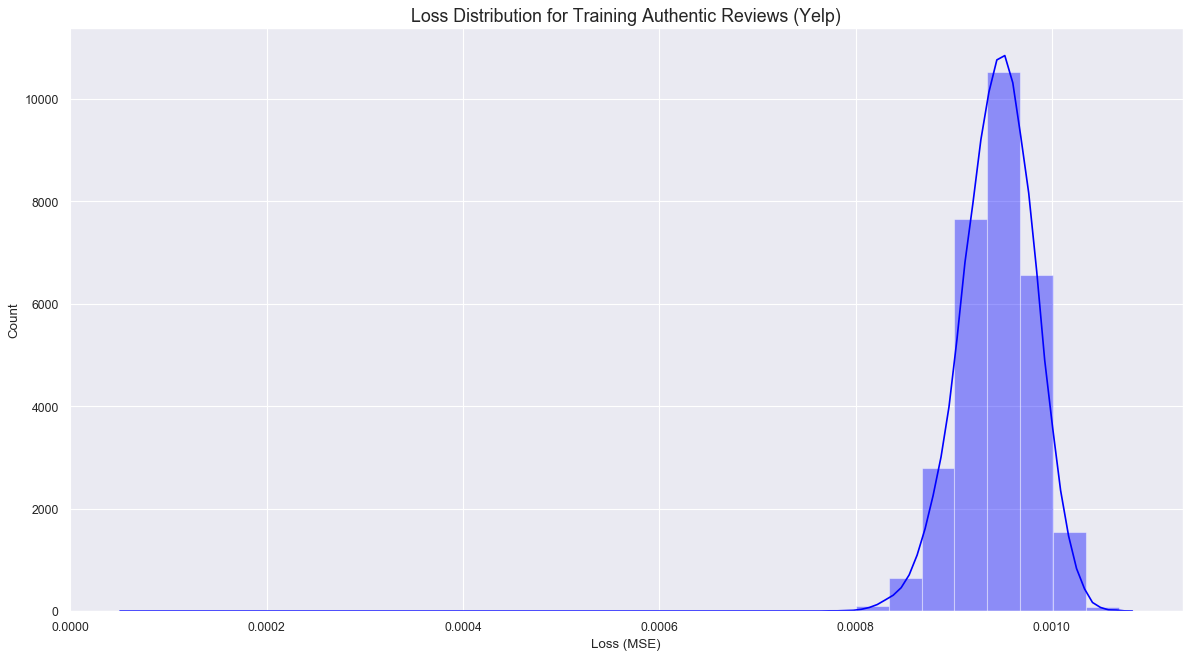

In [706]:
#try plotting with seaborn 
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution for Training Authentic Reviews (Yelp)', fontsize= 16)
sns.distplot(X_true_train_loss, bins =30, kde= True, color= 'blue');
plt.xlabel('Loss (MSE)')
plt.ylabel('Count')
plt.savefig('LossDistTrainTrueYelp.png')

In [697]:
#get a list of deceptive loss values so we can plot the histogram
decep_loss = []
for i in range(X_true_train.shape[0]):
    decep_loss.append(model3.evaluate(decep_samp_vec.values[i].reshape(1,1001),decep_samp_vec.values[i].reshape(1,1001))[0])

1/1 [==============================] - 0s 2ms/sample - loss: 9.9579e-04 - mse: 9.9579e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.8724e-04 - mse: 9.8724e-04


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 6ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.8747e-04 - mse: 9.8747e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.7476e-04 - mse: 9.7476e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 6ms/sample - loss: 9.8979e-04 - mse: 9.8979e-04


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.8150e-04 - mse: 9.8150e-04


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 5ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 5ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 5ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 1ms/sample - loss: 9.8896e-04 - mse: 9.8896e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 5ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.9457e-04 - mse: 9.9457e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 4ms/sample - loss: 0.0011 - mse: 0.0011


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 5ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 4ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 11ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 1ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 4ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 11ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 4ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.7697e-04 - mse: 9.7697e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.8983e-04 - mse: 9.8983e-04


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 9ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 7ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 4ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.6760e-04 - mse: 9.6760e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 9.7250e-04 - mse: 9.7250e-04


1/1 [==============================] - 0s 10ms/sample - loss: 9.9789e-04 - mse: 9.9789e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 4ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 19ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 9ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 8ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.8711e-04 - mse: 9.8711e-04


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 7ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.8111e-04 - mse: 9.8111e-04


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.8801e-04 - mse: 9.8801e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.8962e-04 - mse: 9.8962e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.6250e-04 - mse: 9.6250e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.8906e-04 - mse: 9.8906e-04


1/1 [==============================] - 0s 1ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 6ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 4ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.6798e-04 - mse: 9.6798e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 9.9516e-04 - mse: 9.9516e-04


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.8444e-04 - mse: 9.8444e-04


1/1 [==============================] - 0s 1ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 1ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0011 - mse: 0.0011


1/1 [==============================] - 0s 2ms/sample - loss: 9.9831e-04 - mse: 9.9831e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0011 - mse: 0.0011


1/1 [==============================] - 0s 1ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 1ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 6ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0011 - mse: 0.0011


1/1 [==============================] - 0s 1ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.9216e-04 - mse: 9.9216e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.9422e-04 - mse: 9.9422e-04


1/1 [==============================] - 0s 1ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 1ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 1ms/sample - loss: 9.9731e-04 - mse: 9.9731e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.7988e-04 - mse: 9.7988e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0011 - mse: 0.0011


1/1 [==============================] - 0s 2ms/sample - loss: 9.9328e-04 - mse: 9.9328e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.9251e-04 - mse: 9.9251e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 10ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 1ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0011 - mse: 0.0011


1/1 [==============================] - 0s 1ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 1ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 1ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 1ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 54ms/sample - loss: 9.9608e-04 - mse: 9.9608e-04


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 1ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 9.8947e-04 - mse: 9.8947e-04


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.8247e-04 - mse: 9.8247e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 4ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 9.8432e-04 - mse: 9.8432e-04


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.9099e-04 - mse: 9.9099e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.9701e-04 - mse: 9.9701e-04


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.6995e-04 - mse: 9.6995e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.9195e-04 - mse: 9.9195e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 9.8206e-04 - mse: 9.8206e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.9306e-04 - mse: 9.9306e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.9512e-04 - mse: 9.9512e-04


1/1 [==============================] - 0s 1ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 1ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.9941e-04 - mse: 9.9941e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 12ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.9230e-04 - mse: 9.9230e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.9479e-04 - mse: 9.9479e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.8881e-04 - mse: 9.8881e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.7660e-04 - mse: 9.7660e-04


1/1 [==============================] - 0s 6ms/sample - loss: 9.9902e-04 - mse: 9.9902e-04


1/1 [==============================] - 0s 1ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 4ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 21ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.5930e-04 - mse: 9.5930e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.9384e-04 - mse: 9.9384e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.7625e-04 - mse: 9.7625e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.7357e-04 - mse: 9.7357e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0011 - mse: 0.0011


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 5ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.7456e-04 - mse: 9.7456e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.8755e-04 - mse: 9.8755e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.9304e-04 - mse: 9.9304e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.8400e-04 - mse: 9.8400e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 9.8437e-04 - mse: 9.8437e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.9477e-04 - mse: 9.9477e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.9535e-04 - mse: 9.9535e-04


1/1 [==============================] - 0s 1ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 18ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.7036e-04 - mse: 9.7036e-04


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.9164e-04 - mse: 9.9164e-04


1/1 [==============================] - 0s 1ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.7632e-04 - mse: 9.7632e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.9463e-04 - mse: 9.9463e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.6739e-04 - mse: 9.6739e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0011 - mse: 0.0011


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 1ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 1ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0011 - mse: 0.0011


1/1 [==============================] - 0s 2ms/sample - loss: 9.9590e-04 - mse: 9.9590e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.8779e-04 - mse: 9.8779e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.9102e-04 - mse: 9.9102e-04


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0011 - mse: 0.0011


1/1 [==============================] - 0s 2ms/sample - loss: 9.9776e-04 - mse: 9.9776e-04


1/1 [==============================] - 0s 4ms/sample - loss: 9.8647e-04 - mse: 9.8647e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.9495e-04 - mse: 9.9495e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 10ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.7460e-04 - mse: 9.7460e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.8981e-04 - mse: 9.8981e-04


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.8923e-04 - mse: 9.8923e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.7255e-04 - mse: 9.7255e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 1ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 1ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.8881e-04 - mse: 9.8881e-04


1/1 [==============================] - 0s 1ms/sample - loss: 9.8285e-04 - mse: 9.8285e-04


1/1 [==============================] - 0s 1ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.4961e-04 - mse: 9.4961e-04


1/1 [==============================] - 0s 5ms/sample - loss: 9.9737e-04 - mse: 9.9737e-04


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 7ms/sample - loss: 9.6677e-04 - mse: 9.6677e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.9209e-04 - mse: 9.9209e-04


1/1 [==============================] - 0s 4ms/sample - loss: 9.9515e-04 - mse: 9.9515e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 1ms/sample - loss: 9.9633e-04 - mse: 9.9633e-04


1/1 [==============================] - 0s 2ms/sample - loss: 9.8743e-04 - mse: 9.8743e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.7967e-04 - mse: 9.7967e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 9.9584e-04 - mse: 9.9584e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.7846e-04 - mse: 9.7846e-04


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 9.9804e-04 - mse: 9.9804e-04


1/1 [==============================] - 0s 3ms/sample - loss: 0.0010 - mse: 0.0010


1/1 [==============================] - 0s 2ms/sample - loss: 0.0010 - mse: 0.0010


In [698]:
with open("decep_loss.txt", "w") as output:
    output.write(str(decep_loss))

In [724]:
print(min(X_true_train_loss), max(X_true_train_loss))
print(min(decep_loss), max(decep_loss))

6.460853182943538e-05 0.0010680601699277759
6.460509757744148e-05 0.0010725477477535605


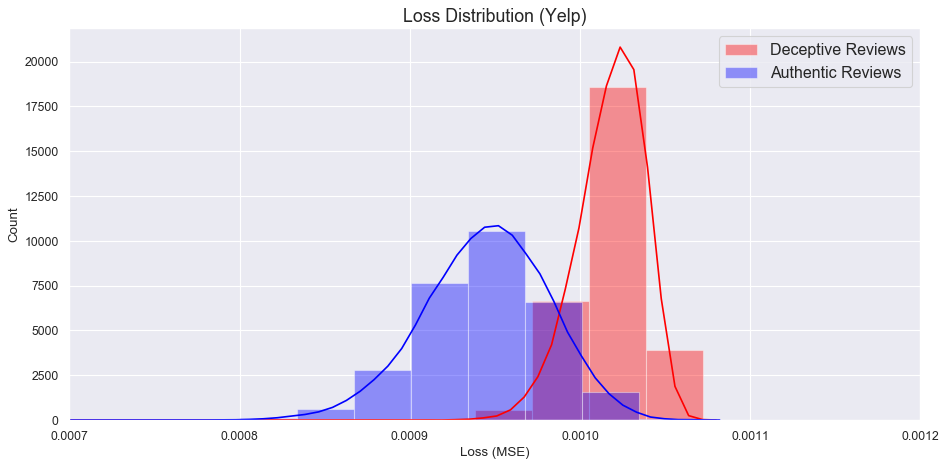

In [797]:
#try plotting with seaborn 
plt.figure(figsize=(12,6), dpi=80)
plt.title('Loss Distribution (Yelp)', fontsize= 16)
sns.distplot(decep_loss, bins =30, kde= True, color= 'red', label=True)
sns.distplot(X_true_train_loss, bins =30, kde= True, color= 'blue', label=True)
plt.legend(['Deceptive Reviews', 'Authentic Reviews'], fontsize = 'large')
plt.xlabel('Loss (MSE)')
plt.ylabel('Count')
plt.xlim([0.0007,0.0012])
plt.tight_layout()
plt.savefig('img/LossDistYelp.png')

In [ ]:
#need to test accuracy by building confusion matrix for different thresholds
#ROC CURVE

setting anomaly threshold at 0.00094 - almost all fake reviews will be classified as anomaly
while some authentic reviews will be classified as fake but now we can be really sure that 
no fake will be in the set at all

In [983]:
true_df = pd.DataFrame(X_true_train_loss, columns =['Loss(MSE)'])
decep_df = pd.DataFrame(decep_loss, columns=['Loss(MSE)'])

In [984]:
def calculate_confusion(true_frame,decep_frame, threshold):
    '''
    input
    true_frame: DataFrame/ loss(MSE) dataframe for true reviews
    decep_frame: DataFrame/ loss(MSE) dataframe for deceptive reviews
    threshold: float/ threshold to determine anomaly (if loss> threshold, then it anomaly)
    
    output
    FP, TN, TP, FN, precision, recall
    '''
    true_frame['Threshold'] = threshold
    true_frame['Anomaly'] = true_frame['Loss(MSE)'] > true_frame['Threshold']
       
    decep_frame['Threshold'] = threshold
    decep_df['Anomaly'] = decep_frame['Loss(MSE)'] > decep_frame['Threshold']

    FP, TN, TP, FN = true_frame['Anomaly'].values.sum(), (~true_frame['Anomaly']).values.sum(), decep_frame['Anomaly'].values.sum(), (~decep_frame['Anomaly']).values.sum()
    
    #calculate precision and recall
    precision = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
    
    cm = np.array([[TN, FP],[FN, TP]])
    fig, ax= plt.subplots(figsize = (5,5))
    sns.heatmap(cm, ax=ax, annot=True, fmt='d')
    ax.set_xlabel('Predicted labels', fontsize = 15);ax.set_ylabel('True labels', fontsize = 15); 
    ax.set_title('Confusion Matrix (Threshold = {})'.format(threshold), fontsize =15)
    plt.tight_layout()
    plt.savefig('img/CM{}.png'.format(threshold))
        
    return FP, TN, TP, FN, precision, recall

(2331, 37669, 33040, 6960, 0.934098555313675, 0.826)

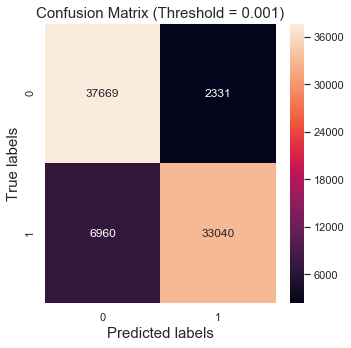

In [985]:
calculate_confusion(true_df, decep_df, 0.001)

(22722, 17278, 39970, 30, 0.6375614113443502, 0.99925)

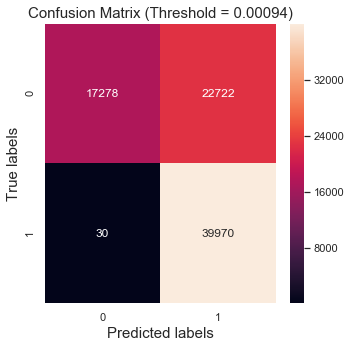

In [986]:
calculate_confusion(true_df, decep_df, 0.00094)

(20, 39980, 999, 39001, 0.9803729146221786, 0.024975)

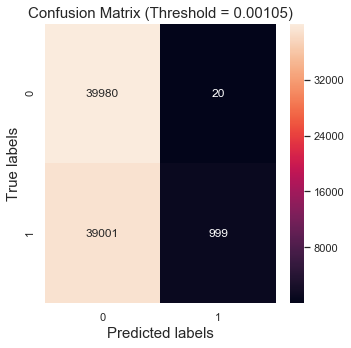

In [869]:
calculate_confusion(true_df, decep_df, 0.00105)

(14038, 25962, 39778, 222, 0.7391482087111639, 0.99445)

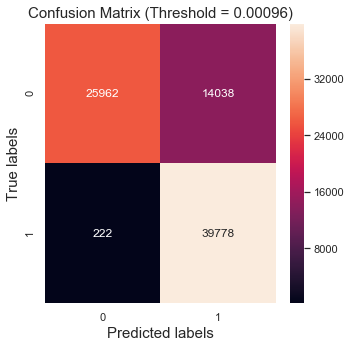

In [921]:
calculate_confusion(true_df, decep_df, 0.00096)

In [919]:
def precision_recall(true_frame,decep_frame, threshold):
    '''
    input
    true_frame: DataFrame/ loss(MSE) dataframe for true reviews
    decep_frame: DataFrame/ loss(MSE) dataframe for deceptive reviews
    threshold: float/ threshold to determine anomaly (if loss> threshold, then it anomaly)
    
    output
    FP, TN, TP, FN, precision, recall
    '''
    true_frame['Threshold'] = threshold
    true_frame['Anomaly'] = true_frame['Loss(MSE)'] > true_frame['Threshold']
       
    decep_frame['Threshold'] = threshold
    decep_df['Anomaly'] = decep_frame['Loss(MSE)'] > decep_frame['Threshold']

    FP, TN, TP, FN = true_frame['Anomaly'].values.sum(), (~true_frame['Anomaly']).values.sum(), decep_frame['Anomaly'].values.sum(), (~decep_frame['Anomaly']).values.sum()
    
    #calculate precision and recall
    precision = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
        
    return precision, recall

In [922]:
precisions = []
recalls = []
thresholds = np.arange(min(decep_loss), max(decep_loss),0.000001)
for i in thresholds:
    p, r = precision_recall(true_df, decep_df, i)
    precisions.append(p)
    recalls.append(r)

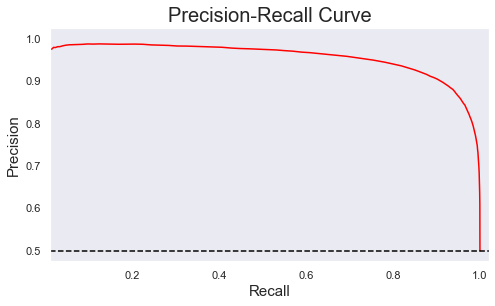

In [967]:
fig, ax = plt.subplots(figsize = (7,4))
plt.plot(recalls, precisions, color = 'red',)
plt.title('Precision-Recall Curve', fontsize = 20 )
plt.xlabel('Recall', fontsize=15)
plt.ylabel('Precision', fontsize =15)
plt.xlim([0.01,1.02])
plt.grid(b=None)
ax.axhline(0.5, color = 'black', linestyle='--')
plt.savefig('img/precision_recall.png')

In [917]:
thresholds= np.arange(min(decep_loss), max(decep_loss),0.000001)

In [968]:
print(min(X_true_train_loss), max(X_true_train_loss))
print(min(decep_loss), max(decep_loss))

6.460853182943538e-05 0.0010680601699277759
6.460509757744148e-05 0.0010725477477535605


(array([847.,  19.,  15.,  11.,  10.,   9.,  10.,  13.,  20.,  54.]),
 array([0.499975 , 0.5499775, 0.59998  , 0.6499825, 0.699985 , 0.7499875,
        0.79999  , 0.8499925, 0.899995 , 0.9499975, 1.       ]),
 <a list of 10 Patch objects>)

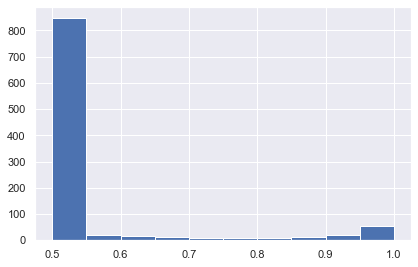

In [972]:
plt.hist(precisions)

(array([ 31.,   6.,   5.,   5.,   5.,   5.,   6.,   7.,  10., 928.]),
 array([2.500000e-05, 1.000125e-01, 2.000000e-01, 2.999875e-01,
        3.999750e-01, 4.999625e-01, 5.999500e-01, 6.999375e-01,
        7.999250e-01, 8.999125e-01, 9.999000e-01]),
 <a list of 10 Patch objects>)

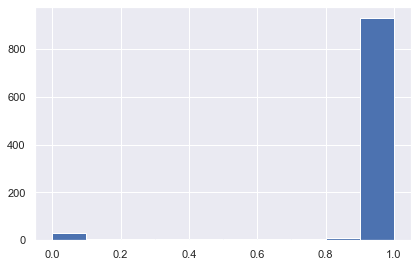

In [971]:
plt.hist(recalls)